# Milestone I

We aim to explore the link between farm productivity and pesticide use, considering the effects of temperature and rainfall. We want to identify countries that have boosted crop yields without increasing pesticide use. By studying these nations, we seek to uncover methods for better sustainable farming. Our key question is: “Which countries have raised crop output while stabilizing or reducing pesticide use, and how do weather conditions factor in?” Sustainable farming is crucial to being good sheppard of our planet's finite resources. The overuse of pesticides can degrade soil quality, harm wildlife, and even contaminate water supplies which can be a health hazard to humans. In an era where food security and environmental health are intertwined, it is important to find ways to to reduce our dependence on pesticides. By answering our question, we hope to provide insights that can be applied globally, a roadmap for agricultural practices, a way to nurture land and its inhabitants. We want to highlight sustainable farming and bring value to this context.

In [128]:
import requests
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import numpy as np
import altair as alt
import geopandas as gpd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from IPython.display import display, Markdown


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Datasets

In [129]:
# pest_df = pd.read_csv('./data/pesticides.csv')
# yield_df = pd.read_csv('./data/yield.csv')

In [130]:
yield_url = 'https://fenixservices.fao.org/faostat/static/bulkdownloads/Production_Crops_Livestock_E_All_Data_(Normalized).zip'
pest_url = 'https://fenixservices.fao.org/faostat/static/bulkdownloads/Inputs_Pesticides_Use_E_All_Data_(Normalized).zip'

response = requests.get(yield_url)
zip_file = ZipFile(BytesIO(response.content))
csv_file = 'Production_Crops_Livestock_E_All_Data_(Normalized).csv'
yield_df = pd.read_csv(zip_file.open(csv_file), encoding='ISO-8859-1')

response = requests.get(pest_url)
zip_file = ZipFile(BytesIO(response.content))
csv_file = 'Inputs_Pesticides_Use_E_All_Data_(Normalized).csv'
pest_df = pd.read_csv(zip_file.open(csv_file), encoding='ISO-8859-1')

In [131]:
rain_df = pd.read_csv('./data/rainfall.csv')
temp_df = pd.read_csv('./data/temp.csv')

# Explore Datasets

In [132]:
# Function to print various data attributes
def print_info(df, name):
    # display(Markdown(f'### **{name}**'))
    display(Markdown('**Dataframe info:**'))
    print(df.info())
    print('\n')
    display(Markdown('**Number of unique values per column:**'))
    print(df.nunique())
    print('\n')
    display(Markdown('**Summary statistics per column:**'))
    print(df.describe().round(0).astype(int))
    print('\n')

    display(Markdown('**Columns with missing values in df:**'))
    missing_values = df.isna().sum()
    print(missing_values[missing_values > 0].to_string(header=False))
    print('\n')

## Temperature data
temp.csv > temp_df
The dataset contains information about average annual temperature across different years and countries.ay be needed.

In [133]:
print_info(temp_df, 'temp_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71311 entries, 0 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      71311 non-null  int64  
 1   country   71311 non-null  object 
 2   avg_temp  68764 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None




**Number of unique values per column:**

year         271
country      137
avg_temp    3303
dtype: int64




**Summary statistics per column:**

        year  avg_temp
count  71311     68764
mean    1906        16
std       67         8
min     1743       -14
25%     1858        10
50%     1910        16
75%     1962        24
max     2013        31




**Columns with missing values in df:**

avg_temp    2547




### Comments:

##### Attributes:
 - year: The year in which the data was collected.
 - country: The name of the country.
 - avg_temp: The average annual temperature in presumably degrees Celsius (although the unit is not explicitly stated).

##### Note:
There are some missing values in the avg_temp column. These will need to be addressed in the data preprocessing stage.

## Rain data
rain.cvs > rain_df

In [134]:
print_info(rain_df, 'rain_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6727 entries, 0 to 6726
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0    Area                          6727 non-null   object
 1   Year                           6727 non-null   int64 
 2   average_rain_fall_mm_per_year  5953 non-null   object
dtypes: int64(1), object(2)
memory usage: 157.8+ KB
None




**Number of unique values per column:**

 Area                            217
Year                              31
average_rain_fall_mm_per_year    173
dtype: int64




**Summary statistics per column:**

       Year
count  6727
mean   2001
std      10
min    1985
25%    1993
50%    2001
75%    2010
max    2017




**Columns with missing values in df:**

average_rain_fall_mm_per_year    774




### Comments:

##### Attributes:
 - Area: This seems to represent geographical areas, likely countries.
 - Year: This represents the year for the data point.
 - average_rain_fall_mm_per_year: average rainfall in mm per year for the given area and year.

##### Notes:

Data type inconsistencies can hinder numerical analyses and visualizations. The presence of string data in what should be a numeric column (average_rain_fall_mm_per_year) will need conversion to float or integer for meaningful statistical operations.

The broad scope in terms of years and areas provides a rich dataset but also introduces complexity when combining with other datasets. Data alignment and aggregation may be needed.

## Pesticide Use
pesticides.cvs > pest_df

In [135]:
print_info(pest_df, 'pest_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112350 entries, 0 to 112349
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Area Code        112350 non-null  int64  
 1   Area Code (M49)  112350 non-null  object 
 2   Area             112350 non-null  object 
 3   Item Code        112350 non-null  int64  
 4   Item             112350 non-null  object 
 5   Element Code     112350 non-null  int64  
 6   Element          112350 non-null  object 
 7   Year Code        112350 non-null  int64  
 8   Year             112350 non-null  int64  
 9   Unit             112350 non-null  object 
 10  Value            112350 non-null  float64
 11  Flag             112350 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 10.3+ MB
None




**Number of unique values per column:**

Area Code            254
Area Code (M49)      254
Area                 254
Item Code             47
Item                  47
Element Code           4
Element                4
Year Code             32
Year                  32
Unit                   4
Value              33890
Flag                   4
dtype: int64




**Summary statistics per column:**

       Area Code  Item Code  Element Code  Year Code    Year    Value
count     112350     112350        112350     112350  112350   112350
mean         804       1338          5159       2006    2006     6569
std         1760         17             5          9       9    65038
min            1       1309          5157       1990    1990        0
25%           74       1321          5157       1998    1998        0
50%          147       1341          5157       2006    2006        8
75%          217       1357          5157       2014    2014      270
max         5817       1357          5173       2021    2021  3535375




**Columns with missing values in df:**

Series([], )




### Comments:

##### Attributes:
 - Domain: Appears to indicate the subject area of the data, which is 'Pesticides Use' in this case.
 - Area: The geographical area, which looks like the name of the country.
 - Element: Specifies what the data represents, i.e., 'Use' of pesticides.
 - Item: The type of pesticide used. It is listed as 'Pesticides (total)' in the initial rows.
 - Year: The year in which the data was collected.
 - Unit: The unit of measurement, which is 'tonnes of active ingredients'.
 - Value: The actual value, representing the amount of pesticides used.

## Crop Yields
The dataset contains 56,717 records and 12 columns.

In [136]:
print_info(yield_df, 'yield_df')

**Dataframe info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761168 entries, 0 to 3761167
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Area Code        int64  
 1   Area Code (M49)  object 
 2   Area             object 
 3   Item Code        int64  
 4   Item Code (CPC)  object 
 5   Item             object 
 6   Element Code     int64  
 7   Element          object 
 8   Year Code        int64  
 9   Year             int64  
 10  Unit             object 
 11  Value            float64
 12  Flag             object 
dtypes: float64(1), int64(5), object(7)
memory usage: 373.0+ MB
None




**Number of unique values per column:**

Area Code             245
Area Code (M49)       245
Area                  245
Item Code             301
Item Code (CPC)       301
Item                  301
Element Code           18
Element                 9
Year Code              61
Year                   61
Unit                   12
Value              941901
Flag                    5
dtype: int64




**Summary statistics per column:**

       Area Code  Item Code  Element Code  Year Code     Year       Value
count    3761168    3761168       3761168    3761168  3761168     3761168
mean        1487        830          5409       1994     1994     2477943
std         2304       1165           103         17       17    27727895
min            1         15          5111       1961     1961           0
25%           89        339          5312       1979     1979        2600
50%          170        600          5419       1995     1995       23164
75%         5000       1058          5510       2008     2008      156153
max         5817      17530          5513       2021     2021  3070645413




**Columns with missing values in df:**

Series([], )




### Comments:

##### Attributes:
 - Domain Code, Domain, Element Code, Element, and Unit: These columns contain only 1 unique value and are likely to be redundant for analysis.
 - Area Code and Area: Represent the geographical location with 212 unique areas.
 - Item Code and Item: Indicate the type of crop, with 10 unique crop types.
 - Year Code and Year: Represent the year data was collected, with 56 unique years.
 - Value: Represents crop yield and contains 36,815 unique val

##### Notes:

The data types are mixed: integer types (Area Code, Element Code, Item Code, Year Code, Year, Value) and object types (Domain Code, Domain, Area, Element, Item, Unit).ues.

# Data Cleaning

## Columns (Data fields)

### Column Transformations
We will rename some columns to be consistent among the dataframes and make it easier to merge data later on. Also, we will subset the dataframes to take only columns of interest

In [137]:
temp_df.rename(columns = {'year':'Year','country':'Country','avg_temp':'Temperature'},inplace = True)
rain_df.rename(columns = {' Area':'Country','average_rain_fall_mm_per_year':'Rainfall'},inplace = True)
yield_df.rename(columns = {'Area':'Country','Value':'Yield'},inplace = True)
pest_df.rename(columns = {'Area':'Country','Value':'Pesticides'},inplace = True)

pest_df = pest_df[['Country', 'Year', 'Pesticides']]
yield_df = yield_df[['Country', 'Item', 'Year', 'Yield', 'Element Code']]

### Yield Transformations
The yield dataset contains information on individual crops, for our analysis we will combine these and sum the totals for that country by year.

In [138]:
yield_df['Element Code'].unique()

array([5312, 5419, 5510, 5111, 5320, 5112, 5410, 5413, 5513, 5313, 5417,
       5424, 5321, 5420, 5318, 5114, 5314, 5422])

Based on the metadata for the dataset from the FAO, the code 5419 hast the most to do with crop yields, we will subset on this. 

In [139]:
yield_df = yield_df[yield_df['Element Code'] == 5419].groupby(['Country','Year'])['Yield'].sum().reset_index()

In [140]:
yield_df.head(3)

,Country,Year,Yield
0,Afghanistan,1961,1921425.0
1,Afghanistan,1962,1993718.0
2,Afghanistan,1963,1987768.0


### Year ranges

In [141]:
def year_ranges():
    print(f"Year range in temp.csv {temp_df['Year'].min()} - {temp_df['Year'].max()}")
    print(f"Year range in rainfall.csv {rain_df['Year'].min()} - {rain_df['Year'].max()}")
    print(f"Year range in yield.csv {yield_df['Year'].min()} - {yield_df['Year'].max()}")
    print(f"Year range in pesticides.csv {pest_df['Year'].min()} - {pest_df['Year'].max()}")

year_ranges()

Year range in temp.csv 1743 - 2013
Year range in rainfall.csv 1985 - 2017
Year range in yield.csv 1961 - 2021
Year range in pesticides.csv 1990 - 2021


## Data Integrity Findings

### Country Names

The country names between the pesticides and yield datasets have some inconsistencies, we can view the values that are present in the yield dataset but not in the pesticide dataset. As we can see there are several that don't make sense, such as Netherlands, United Kingdom, and Turkey. ON review of the countries in the pesticides dataset, we note that 'Türkiye', 'United Kingdom of Great Britain and Northern Ireland', and 'Netherlands (Kingdom of the)' are listed. 

In [142]:
unique_values_yield = yield_df.loc[~yield_df['Country'].isin(pest_df['Country']), 'Country'].unique()
unique_values_yield

array(['Afghanistan', 'Dominica', 'Guadeloupe', 'Guyana',
       'Marshall Islands', 'Martinique', 'Micronesia', 'Netherlands',
       'Puerto Rico', 'Réunion', 'Singapore', 'South Sudan',
       'United Arab Emirates', 'Uzbekistan'], dtype=object)

In [143]:
replacements = {
    'Türkiye': 'Turkey',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Netherlands (Kingdom of the)':'Netherlands'
}

pest_df['Country'] = pest_df['Country'].replace(replacements)

### Missing Values
Both the rainfall and temp datasets have missing values, and we will need to explore these datasets further to understand why these data are missing, whether they are missing completely at random, missing at random, or not at random. Is there some pattern or reason that they may be missing? With these types of datasets, given the time frame on the rainfall and temperature datasets, data may not be available due to the time frame; likely, it was never collected or not available that long ago. Also, given that we are looking at data by country, some countries may not report their data. We suspect some values may be missing at random, but we believe it's more likely due to the aforementioned systemically missing values. Let's investigate.  

#### temp.csv
We hypothesize that the missing values might be systematically absent or unavailable for specific time periods. To delve deeper into this, we'll employ the Altair visualization library to plot the frequency of these missing values and identify potential concentrations. Given the extensive range of years in this dataset, we've opted to group them into bins for a clearer visualization. Grouping the data in 10-year intervals strikes a balance between granularity and clarity, enabling us to pinpoint where values may be absent.

In [144]:
bin_size = 10
min_year_temp = temp_df["Year"].min()
max_year_temp = temp_df["Year"].max()
bins_temp = list(range(int(min_year_temp), int(max_year_temp) + bin_size, bin_size))

bin_labels_temp = [f"{i}-{i + bin_size - 1}" for i in bins_temp[:-1]]
temp_df["Year_Bin"] = pd.cut(temp_df["Year"], bins=bins_temp, labels=bin_labels_temp, right=False)
temp_missing_by_bin = temp_df.groupby("Year_Bin", observed=True)["Temperature"].apply(lambda x: x.isnull().mean())

temp_missing_df = temp_missing_by_bin.reset_index()
temp_missing_df.columns = ['Year_Bin', 'Missing_Proportion']

temp_chart = alt.Chart(temp_missing_df).mark_bar().encode(
    x=alt.X('Year_Bin:O', title='Year Bin', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Missing_Proportion:Q', title='Average Proportion of Missing Values'),
    tooltip=['Year_Bin', 'Missing_Proportion']
).properties(
    title='Average Proportion of Missing Values by Year Bin in Temperature Dataset',
    width=600,
    height=400
)

temp_chart

alt.Chart(...)

From this visualization, we can see that most missing values are from about 1900 and earlier. This supports our hypothesis that the missing values are unavailable from an earlier period for some countries and not due to being missing at random or due to data corruption. To further evaluate this, we can check the count of missing values from 1900 onwards. 



We see that there are no missing temperature values from 1900 onwards. Since our main question related to this project is about pesticide use and it's respective dataset only has data from 2016, we can safely remove these datasets by subsetting the data from 1900 onwards. 





In [145]:
temp_df[temp_df["Year"] >= 1900].isnull().sum()

Year             0
Country          0
Temperature      0
Year_Bin       345
dtype: int64

In [146]:
temp_df_cleaned = temp_df[temp_df["Year"] >= 1900].copy().reset_index()
temp_df_cleaned = temp_df_cleaned.drop(columns=['Year_Bin'])
temp_df_cleaned

,index,Year,Country,Temperature
0,51,1900,Côte D'Ivoire,26.12
1,52,1901,Côte D'Ivoire,25.92
2,53,1902,Côte D'Ivoire,25.59
3,54,1903,Côte D'Ivoire,25.48
4,55,1904,Côte D'Ivoire,25.24
...,...,...,...,...
39325,71306,2009,Mexico,21.76
39326,71307,2010,Mexico,20.90
39327,71308,2011,Mexico,21.55
39328,71309,2012,Mexico,21.52


#### rain_df
Let's do a similar analysis for the rainfall dataset. We also suspect that there may be missing values from earlier periods. 

In [147]:
bin_size = 5
min_year_rainfall = rain_df["Year"].min()
max_year_rainfall = rain_df["Year"].max()
bins_rainfall = list(range(int(min_year_rainfall), int(max_year_rainfall) + bin_size, bin_size))
bin_labels_rainfall = [f"{i}-{i + bin_size - 1}" for i in bins_rainfall[:-1]]

rain_df["Year_Bin"] = pd.cut(rain_df["Year"], bins=bins_rainfall, labels=bin_labels_rainfall, right=False)
rainfall_missing_by_bin = rain_df.groupby("Year_Bin")["Rainfall"].apply(lambda x: x.isnull().mean())

rainfall_missing_by_year = rain_df.groupby("Year")["Rainfall"].apply(lambda x: x.isnull().mean()).reset_index()
rainfall_missing_by_year.columns = ['Year', 'Missing_Proportion']

rainfall_chart = alt.Chart(rainfall_missing_by_year).mark_bar().encode(
    x=alt.X('Year:O', title='Year', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Missing_Proportion:Q', title='Average Proportion of Missing Values'),
    tooltip=['Year', 'Missing_Proportion']
).properties(
    title='Average Proportion of Missing Values by Year in Rainfall Dataset',
    width=600,
    height=400
)

rainfall_chart 

alt.Chart(...)

We can see that the missing values are almost perfectly distributed among all the years, suggesting that they may just be missing at random rather than unavailable or due to some other pattern. However, we should do a similar analysis grouping by country to see if values are missing for specific countries. 

In [148]:
rain_df = rain_df.drop(columns=['Year_Bin'])

In [149]:
rainfall_missing_by_country = rain_df.groupby('Country')['Rainfall'].apply(lambda x: x.isnull().sum()).reset_index()
rainfall_missing_by_country.columns = ['Country', 'Missing_Count']
rainfall_missing_by_country

,Country,Missing_Count
0,Afghanistan,0
1,Albania,0
2,Algeria,0
3,American Samoa,31
4,Andorra,0
...,...,...
212,Virgin Islands (U.S.),31
213,West Bank and Gaza,0
214,Yemen,0
215,Zambia,0


Based on this, only a few countries may be missing values. Let's analyze this to see which ones might be the culprits here. The value of 31

##### Countries with missing rainfall data:

In [150]:
rain_df[rain_df["Rainfall"].isna()]["Country"].unique()

array(['American Samoa', 'Aruba', 'Bermuda', 'British Virgin Islands',
       'Cayman Islands', 'Channel Islands', 'Curacao', 'Faroe Islands',
       'French Polynesia', 'Gibraltar', 'Greenland', 'Guam',
       'Hong Kong SAR, China', 'Isle of Man', 'Kosovo',
       'Macao SAR, China', 'Monaco', 'New Caledonia',
       'Northern Mariana Islands', 'San Marino',
       'Sint Maarten (Dutch part)', 'St. Martin (French part)', 'Tonga',
       'Turks and Caicos Islands', 'Virgin Islands (U.S.)'], dtype=object)

Okay, we can see that only certain countries are missing values, which is interesting. Let's see what this looks like if we graph it.

In [151]:
rainfall_missing_by_country = rainfall_missing_by_country[rainfall_missing_by_country["Missing_Count"] > 0]

rainfall_country_chart = alt.Chart(rainfall_missing_by_country).mark_bar().encode(
    x=alt.X('Country:O', title='Country', axis=alt.Axis(labelAngle=-45)),
    y=alt.Y('Missing_Count:Q', title='Average Proportion of Missing Values'),
    tooltip=['Country', 'Missing_Count']
).properties(
    title='Number of Missing Values by Country in Rainfall Dataset',
    width=600,
    height=400
)

rainfall_country_chart

alt.Chart(...)

This shows that the countries missing values all have 31 missing values, except Monaco, why 30 here?

In [152]:
rain_df[rain_df['Country'] == 'Monaco']['Rainfall'].value_counts()

..    1
Name: Rainfall, dtype: int64

It appears that Monaco has an errant value of `..` for a single row.

##### Discussion

There are only 31 unique values for the year column, so it seem that the missing values are concentrated in the list of countries from above and there are no values for these countries. We could try and supplement our dataset with another dataset that has these values, but is that necessary?

##### Review pesticide dataset and compare with rain data

In [153]:
rain_df.nunique()

Country     217
Year         31
Rainfall    173
dtype: int64

In [154]:
countries_with_missing_rainfall = rain_df[rain_df["Rainfall"].isna()]["Country"].unique()
subset_pest_df = pest_df[pest_df["Country"].isin(countries_with_missing_rainfall)]
subset_pest_df.describe()['Pesticides'].round(0).astype(int)

count    4615
mean       25
std        78
min         0
25%         0
50%         1
75%        12
max       681
Name: Pesticides, dtype: int64

In [155]:
countries_with_missing_rainfall

array(['American Samoa', 'Aruba', 'Bermuda', 'British Virgin Islands',
       'Cayman Islands', 'Channel Islands', 'Curacao', 'Faroe Islands',
       'French Polynesia', 'Gibraltar', 'Greenland', 'Guam',
       'Hong Kong SAR, China', 'Isle of Man', 'Kosovo',
       'Macao SAR, China', 'Monaco', 'New Caledonia',
       'Northern Mariana Islands', 'San Marino',
       'Sint Maarten (Dutch part)', 'St. Martin (French part)', 'Tonga',
       'Turks and Caicos Islands', 'Virgin Islands (U.S.)'], dtype=object)

In [156]:
pest_df.describe()['Pesticides'].round(0).astype(int)

count     112350
mean        6569
std        65038
min            0
25%            0
50%            8
75%          270
max      3535375
Name: Pesticides, dtype: int64

When compared to the rest of the countries we can see that the countries missing data for rainfall have very low amounts of pesticide, suggesting that they may not be useful for our analysis. We decided to remove these rows from the dataset.

In [157]:
rain_df_cleaned = rain_df[~rain_df["Country"].isin(countries_with_missing_rainfall)].copy().reset_index()
rain_df_cleaned.isnull().sum()

index       0
Country     0
Year        0
Rainfall    0
dtype: int64

No more missing values in the rainfall dataset. 

##### Confirm
Now, let's revisit our 4 datasets and check that we have addressed missing values.

In [158]:
print("Missing values in temp_df:", temp_df_cleaned.isna().sum().sum())
print("Missing values in rain_df:", rain_df_cleaned.isna().sum().sum())
print("Missing values in pest_df:", pest_df.isna().sum().sum())
print("Missing values in yield_df:", yield_df.isna().sum().sum())

Missing values in temp_df: 0
Missing values in rain_df: 0
Missing values in pest_df: 0
Missing values in yield_df: 0


Great! We no longer have any missing values in any of the four datasets. Let's move on to data integrity, types.

#### Data Types

In [159]:
rain_df.dtypes

Country     object
Year         int64
Rainfall    object
dtype: object

The Rainfall column is cast as object, which suggests that it may be in string format, but attempting to cast as a float using `rain_df['Rainfall'].astype(float)`, causes an error that it could not convert string to float: `..`

Let's explore this to see what's going on.

In [160]:
rain_df_cleaned['Rainfall'] = rain_df_cleaned['Rainfall'].astype(str)

In [161]:
non_numeric_rain = rain_df_cleaned[~rain_df_cleaned['Rainfall'].str.isnumeric()]
non_numeric_rain['Rainfall'].value_counts()

..    5
Name: Rainfall, dtype: int64

In [162]:
rain_df_cleaned[rain_df_cleaned['Rainfall'] == '..']

,index,Country,Year,Rainfall
341,403,Bahamas,1985,..
342,404,Bahamas,1986,..
344,406,Bahamas,1989,..
345,407,Bahamas,1990,..
346,408,Bahamas,1991,..


In [163]:
rain_df_cleaned[rain_df_cleaned['Rainfall'].isna()]

,index,Country,Year,Rainfall


Since these Countries already have values in the other rows, we can just impute these values with those values. The rainfall dataset has only 217 unique values for the amount of rainfall and on closer inspection it appears that rainfall is the same value each year for each country. This makes it easy to impute the value, but it complicates part of our analysis since this dataset won't give us any information or insight into how yields may have changed over time with respect to changes in rainfall. Although, we can still see if there may be some degree of correlation between amount of rainfall and yield.

In [164]:
rain_df_cleaned.loc[(rain_df_cleaned['Country'] == 'Bahamas') & (rain_df_cleaned['Rainfall'] == '..'), 'Rainfall'] = 1292

In [165]:
rain_df_cleaned['Rainfall'] = rain_df_cleaned['Rainfall'].astype(float)

In [166]:
rain_df_cleaned[rain_df_cleaned['Country'] == 'Bahamas'].describe()

,index,Year,Rainfall
count,31.000000,31.000000,31.0
mean,418.000000,2001.354839,1292.0
std,9.092121,9.686927,0.0
min,403.000000,1985.000000,1292.0
25%,410.500000,1993.500000,1292.0
50%,418.000000,2001.000000,1292.0
75%,425.500000,2009.500000,1292.0
max,433.000000,2017.000000,1292.0


In [167]:
rain_df_cleaned.dtypes

index         int64
Country      object
Year          int64
Rainfall    float64
dtype: object

We now have Rainfall as a float

#### Duplicate Values

In [168]:
temp_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39330 entries, 0 to 39329
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        39330 non-null  int64  
 1   Year         39330 non-null  int64  
 2   Country      39330 non-null  object 
 3   Temperature  39330 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [169]:
year_ranges()

Year range in temp.csv 1743 - 2013
Year range in rainfall.csv 1985 - 2017
Year range in yield.csv 1961 - 2021
Year range in pesticides.csv 1990 - 2021


In [170]:
temp_df_cleaned.nunique()

index          39330
Year             114
Country          137
Temperature     3118
dtype: int64

We see that there are 39,330 rows in this dataset, but we now only have data from 1900 to 2013, 114 years and 137 countries, if we had only 1 value per combination of Country/Year, then we would expect 15,168 rows. Let's investigate for duplicates.

In [171]:
display(Markdown('##### Number of rows for select countries'))
print('United Kingdom:', temp_df_cleaned[temp_df_cleaned['Country'] == 'United Kingdom'].shape[0])
print('United States: ', temp_df_cleaned[temp_df_cleaned['Country'] == 'United States'].shape[0])
print('Bahamas: ',temp_df_cleaned[temp_df_cleaned['Country'] == 'Bahamas'].shape[0])
print('Bahamas unique: ', temp_df_cleaned[temp_df_cleaned['Country'] == 'Bahamas']['Year'].nunique())

##### Number of rows for select countries

United Kingdom: 570
United States:  5928
Bahamas:  114
Bahamas unique:  114


We can see that there are 114 rows for Bahamas and 114 unique years, indicating a single value per year for the Bahamas. However, if we look at other countries such as the United States or United Kingdom, there are many more rows than we would expect if there were just a single value for each year. 

If we produce a dataframe of duplicate counts, we can see that counts vary by country and year over time, with counts increasing over time. If we consider the United States, it goes from 22 up to 52. This suggests that the temp.csv file is missing information. Could these 52 values for the last 165 years represent the states, Puerto Rico, and Guam? This can complicate how we move forward with merging the data.

In [172]:
duplicate_counts_temp = temp_df.groupby(['Year', 'Country']).size().reset_index(name='Count')
duplicate_counts_temp = duplicate_counts_temp[duplicate_counts_temp['Count'] > 1]
duplicate_counts_temp.sort_values(by='Count', ascending=False).head(10)

,Year,Country,Count
27137,2003,United States,52
26589,1999,United States,52
14533,1911,United States,52
8937,1870,United States,52
11108,1886,United States,52
13985,1907,United States,52
24945,1987,United States,52
17547,1933,United States,52
19191,1945,United States,52
23986,1980,United States,52


In [173]:
top_countries = duplicate_counts_temp.groupby('Country')['Count'].sum().nlargest(7).index.tolist()

filtered_data = duplicate_counts_temp[duplicate_counts_temp['Country'].isin(top_countries)]

chart = alt.Chart(filtered_data).mark_line().encode(
    x='Year',
    y='Count',
    color='Country',
    tooltip=['Year', 'Count', 'Country']
).properties(
    title='Duplicate Counts by Year for Top 7 Countries',
    width=600,
    height=300
)

chart

alt.Chart(...)

From this chart we can see that there a few countries with multiple duplicates per year consistently over time. Given that these are larger countries, these temperature values may represent different geographical areas within the country. Again, this can add some complication to our analysis given the missing information.

#### yield_df
The dataset do not contain any missing values in any of its columns. This makes the data cleaning process easier.

### Todo

### Narrow focus

Remove countries that have duplicate values, focus on medium to smaller countries, a specific contiennt, area?
Find data on population? 

### Todo

### Negative values

todo

# Merge

In [174]:
merged_yield_pesticides = yield_df.merge(pest_df, on=['Country', 'Year'], how='inner').reset_index(drop=True)
merged_temp = merged_yield_pesticides.merge(temp_df_cleaned, on=['Country', 'Year'], how='inner').reset_index(drop=True)
merged_df = merged_temp.merge(rain_df_cleaned, on=['Country', 'Year'], how='inner').reset_index(drop=True)
merged_df.drop(columns=['index_x', 'index_y'], errors='ignore', inplace=True)

merged_df

,Country,Year,Yield,Pesticides,Temperature,Rainfall
0,Albania,1990,4368200.0,121.00,16.37,1485.0
1,Albania,1990,4368200.0,0.17,16.37,1485.0
2,Albania,1990,4368200.0,0.04,16.37,1485.0
3,Albania,1990,4368200.0,0.12,16.37,1485.0
4,Albania,1990,4368200.0,70.00,16.37,1485.0
...,...,...,...,...,...,...
83353,Zimbabwe,2013,5208664.0,0.00,19.76,657.0
83354,Zimbabwe,2013,5208664.0,177.70,19.76,657.0
83355,Zimbabwe,2013,5208664.0,0.00,19.76,657.0
83356,Zimbabwe,2013,5208664.0,0.00,19.76,657.0


In [175]:
merged_yield_pesticides

,Country,Year,Yield,Pesticides
0,Africa,1990,8429785.0,73958.66
1,Africa,1990,8429785.0,0.36
2,Africa,1990,8429785.0,0.12
3,Africa,1990,8429785.0,0.49
4,Africa,1990,8429785.0,25495.31
...,...,...,...,...
102703,Zimbabwe,2021,5086704.0,0.41
102704,Zimbabwe,2021,5086704.0,7.24
102705,Zimbabwe,2021,5086704.0,133.40
102706,Zimbabwe,2021,5086704.0,0.00


In [176]:
merged_yield_pesticides.isna().sum()

Country       0
Year          0
Yield         0
Pesticides    0
dtype: int64

In [177]:
merged_df.to_csv('merged_df.csv', index=False)

Todo: make a notation of the units for the merged_df

In [178]:
# Load the dataset
df = pd.read_csv('merged_df.csv')
# Display the first few rows of the dataset
df.head()


,Country,Year,Yield,Pesticides,Temperature,Rainfall
0,Albania,1990,4368200.0,121.00,16.37,1485.0
1,Albania,1990,4368200.0,0.17,16.37,1485.0
2,Albania,1990,4368200.0,0.04,16.37,1485.0
3,Albania,1990,4368200.0,0.12,16.37,1485.0
4,Albania,1990,4368200.0,70.00,16.37,1485.0


In [179]:
# Function to generate summary statistics
def summary_statistics(df):
    """
    Generate summary statistics for the dataset.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    
    Returns:
    - A DataFrame containing the summary statistics.
    """
    return df.describe(include='all')

# Get the summary statistics
summary_stats = summary_statistics(df)
summary_stats


,Country,Year,Yield,Pesticides,Temperature,Rainfall
count,83358,83358.000000,8.335800e+04,83358.000000,83358.000000,83358.000000
unique,109,NaN,NaN,NaN,NaN,NaN
top,India,NaN,NaN,NaN,NaN,NaN
freq,11946,NaN,NaN,NaN,NaN,NaN
mean,NaN,2001.533194,7.828520e+06,9107.366348,18.797537,1095.262698
std,NaN,6.935363,4.096672e+06,34901.796554,7.549539,655.023971
min,NaN,1990.000000,3.431160e+05,0.000000,-3.370000,51.000000
25%,NaN,1996.000000,5.208664e+06,0.850000,12.430000,645.000000
50%,NaN,2001.000000,7.092660e+06,55.090000,20.050000,1083.000000
75%,NaN,2008.000000,1.062819e+07,1858.647500,25.990000,1500.000000


#### summary statistics for the dataset:
- Country:
Data is available for 109 unique countries.
India appears most frequently in the dataset.
- Year:
Data spans from the year 1990 to 2013.
- Yield:
The minimum yield is approximately 343,116.
The maximum yield is approximately 38,137,530.
The average yield is approximately 7,828,520.
- Pesticides:
The minimum value is 0 (indicating no pesticides).
The maximum value is 472,977.15.
The average value is 9,107.37.
- Temperature:
The minimum average temperature is -3.37°C.
The maximum average temperature is 30.65°C.
The average temperature across all entries is 18.8°C.
- Rainfall:
The minimum rainfall is 51 mm.
The maximum rainfall is 3,240 mm.
The average rainfall is approximately 1,095.26 mm.

In [180]:
# Checking for missing values
def check_missing_values(df):
    """
    Check for missing values in the dataset.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    
    Returns:
    - A DataFrame containing the count and percentage of missing values for each column.
    """
    missing_count = df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percentage
    })
    return missing_data

# Check for missing values
missing_values = check_missing_values(df)
missing_values



,Missing Count,Missing %
Country,0,0.0
Year,0,0.0
Yield,0,0.0
Pesticides,0,0.0
Temperature,0,0.0
Rainfall,0,0.0


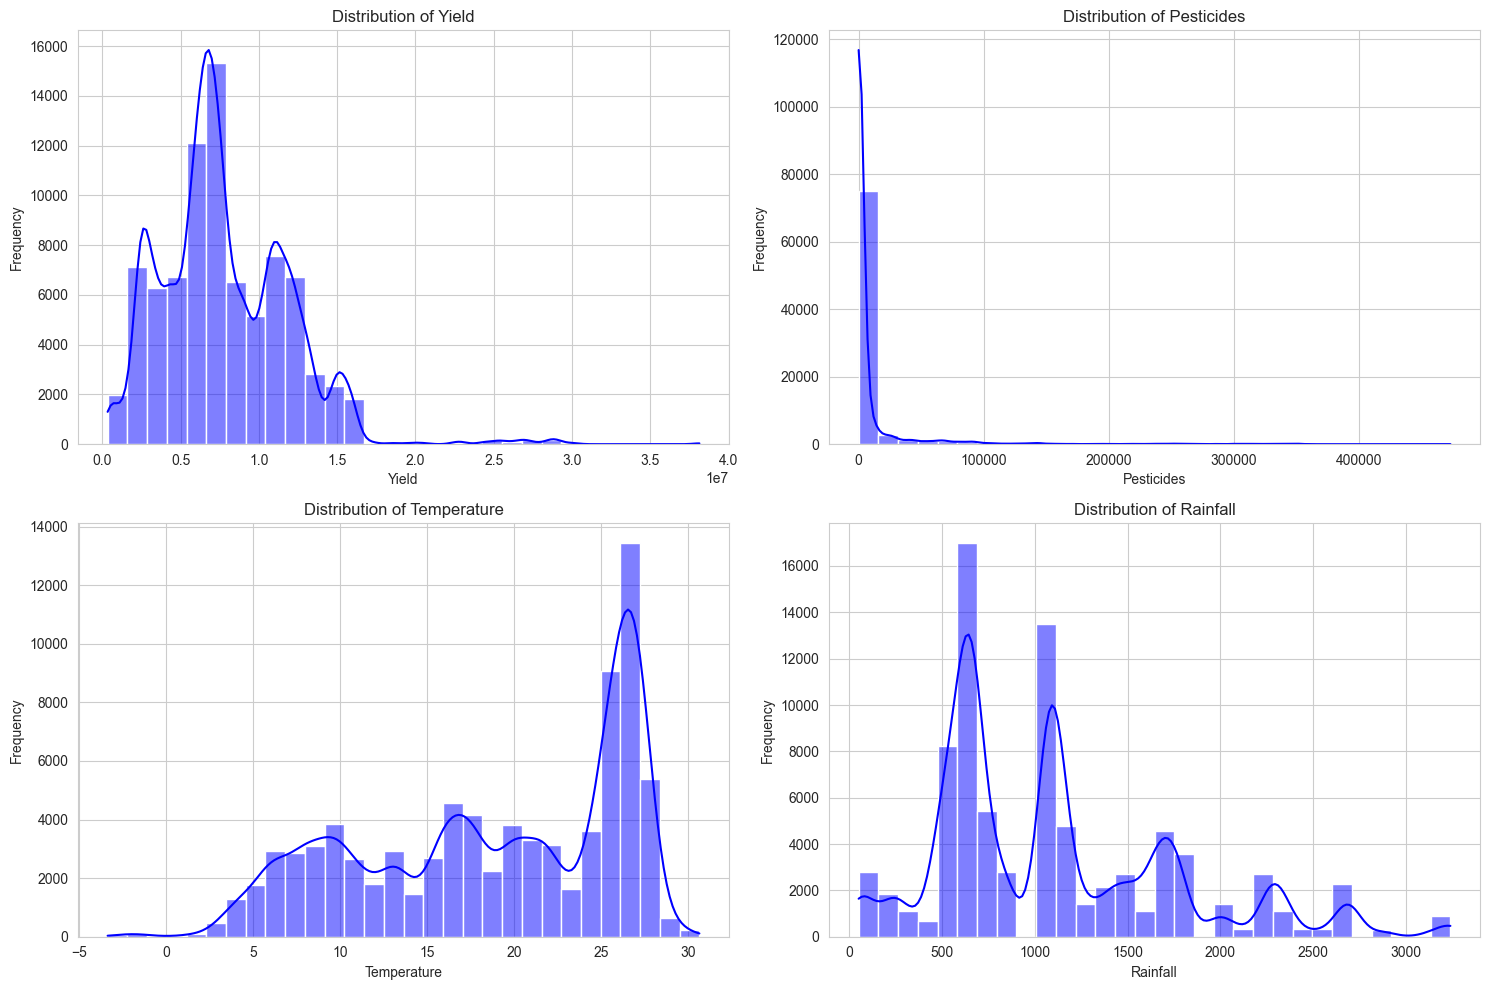

In [185]:
# Function to plot distributions
def plot_distributions(df, columns):
    """
    Plot the distributions for the given columns.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    - columns: List of columns for which distributions should be plotted.
    
    Returns:
    - None (plots the distributions).
    """
    # Set up the aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Loop through columns and plot distributions
    for i, column in enumerate(columns, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[column], kde=True, color='blue',bins=30)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot distributions for continuous variables
columns_to_plot = ['Yield', 'Pesticides', 'Temperature', 'Rainfall']
plot_distributions(df, columns_to_plot)


- Yield:
The distribution is right-skewed, indicating that most of the data points have lower yield values, while a few countries or records have significantly higher yields.
- Pesticides:
The distribution is highly right-skewed. Most of the data points use a smaller amount of pesticides, while there are a few outliers that use a large amount.
- Temperature:
The distribution seems bimodal, indicating there are two peaks. This could be because some countries have colder climates and others have warmer climates.
- Rainfall:
The distribution is slightly left-skewed. Most of the data points have higher rainfall, while a few have very low rainfall.

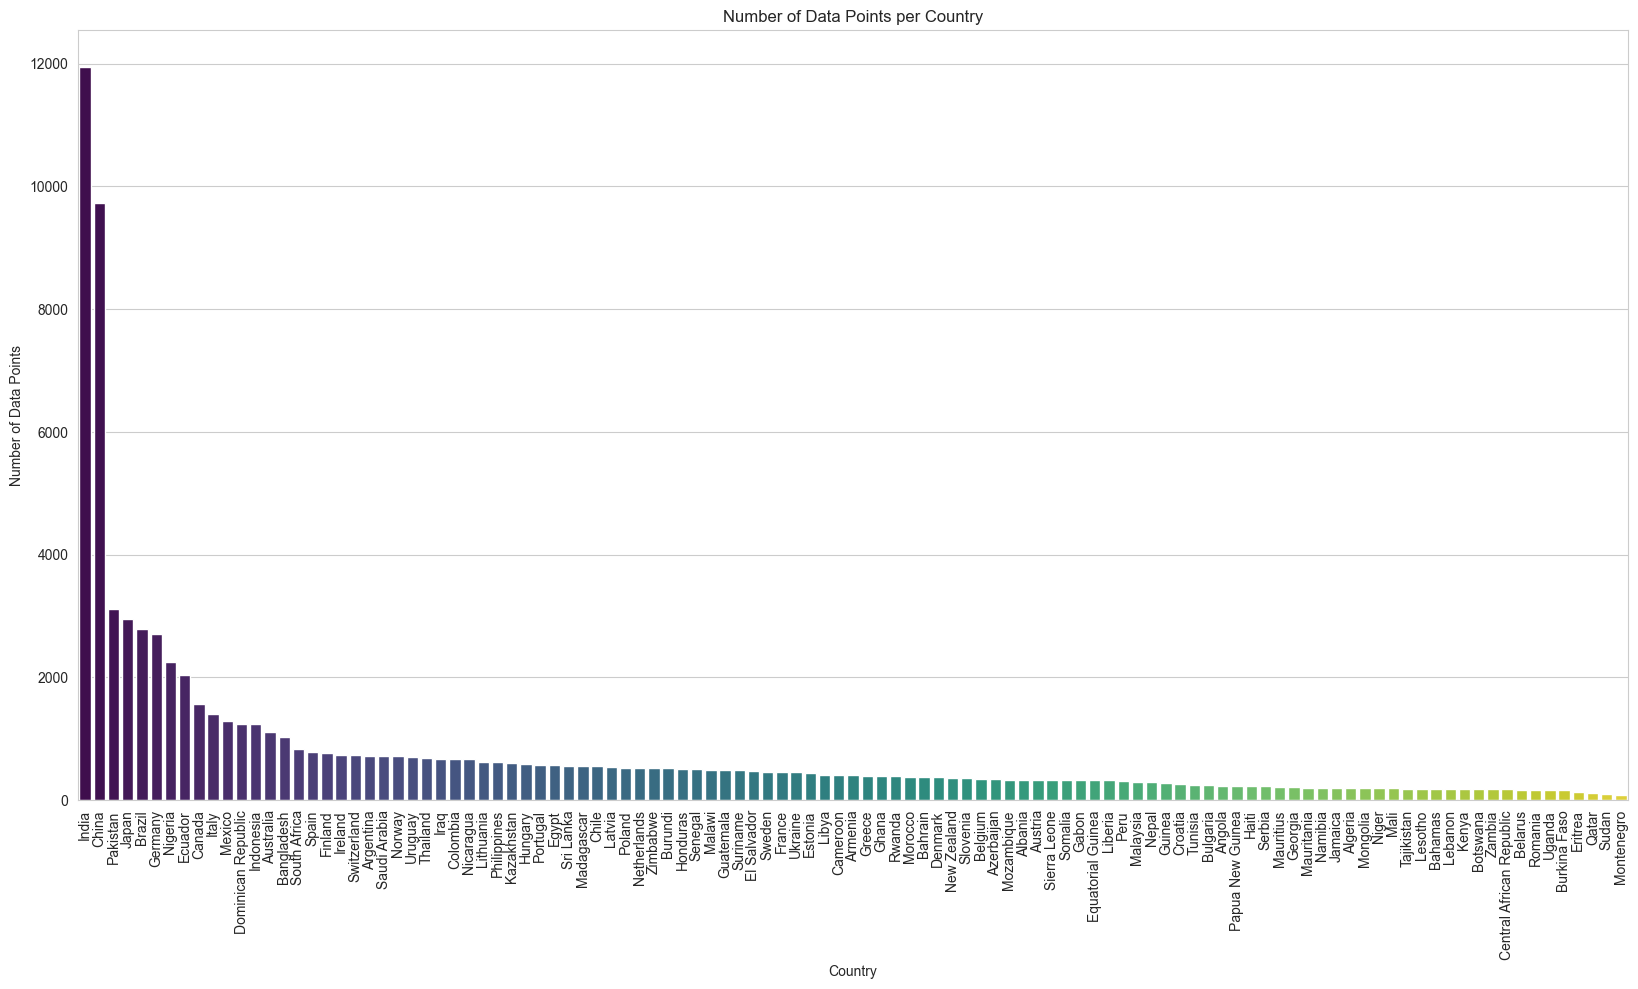

In [186]:
# Plot the distribution of data points for each country
def country_data_points(df):
    """
    Plot the number of data points available for each country.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    
    Returns:
    - None (plots the bar chart).
    """
    # Set up the aesthetics
    plt.figure(figsize=(20, 10))
    
    # Get the count of data points for each country and plot
    country_counts = df['Country'].value_counts()
    sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")
    
    # Set title and labels
    plt.title('Number of Data Points per Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Data Points')
    plt.xticks(rotation=90)
    
    plt.show()

# Plot the number of data points for each country
country_data_points(df)


The bar plot showcases the number of data points available for each country:

Countries like India, China, the USA, and Brazil have a significantly higher number of data points compared to other countries. This could be due to more detailed records, different crops, or other reasons that lead to multiple entries.
Many other countries have a more uniform number of data points.

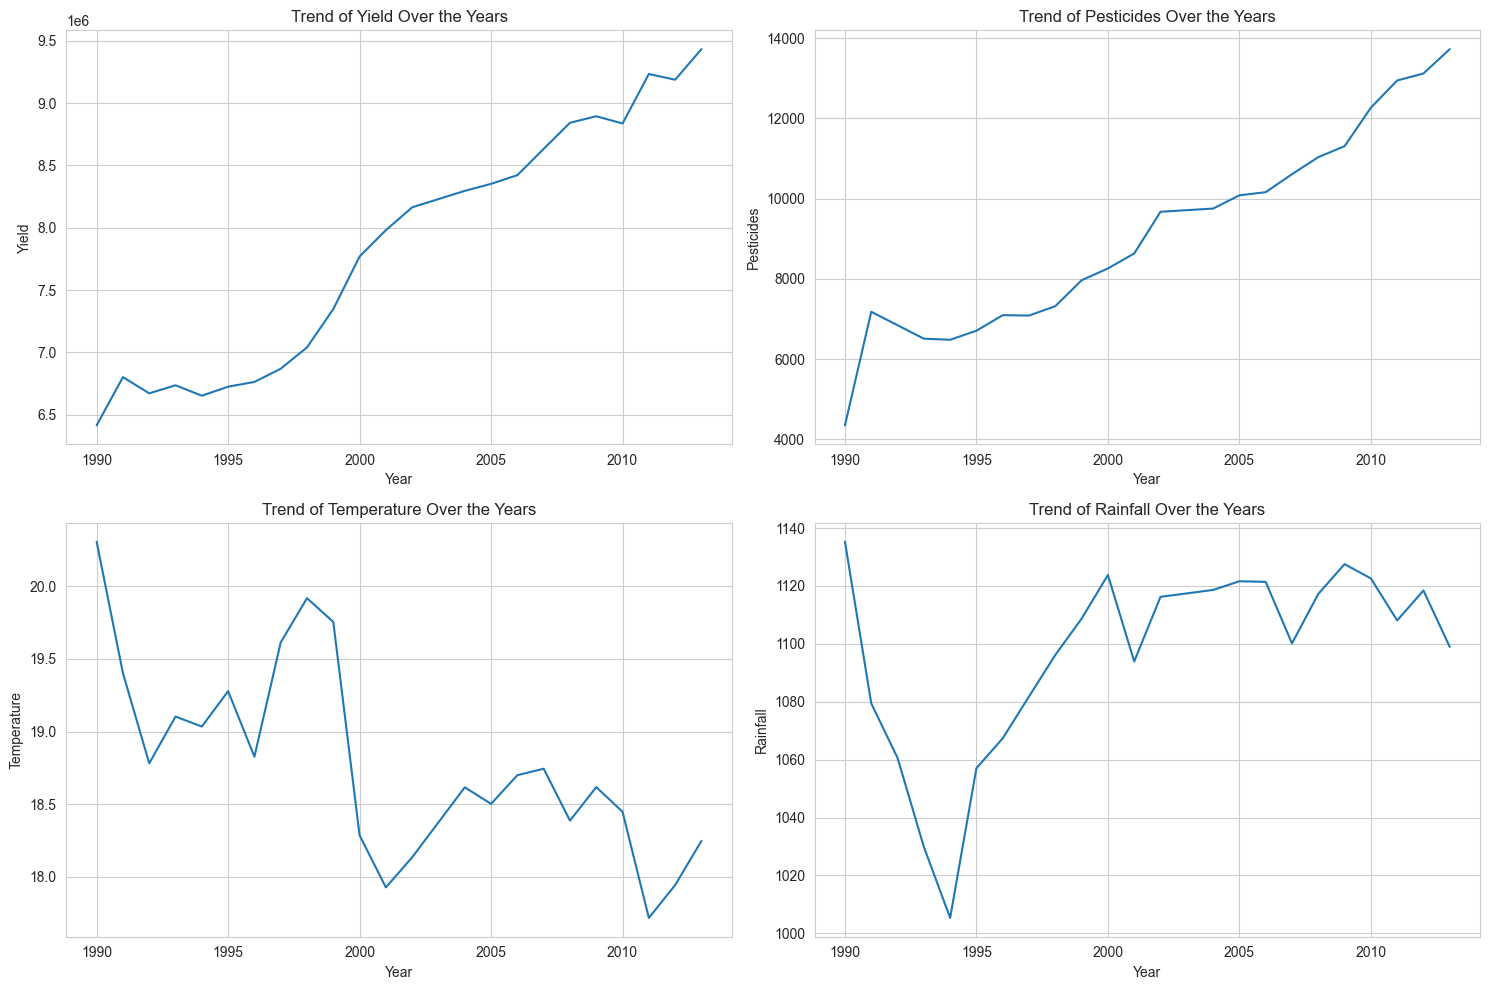

In [187]:
# Plot the distribution of data points over the years
def time_series(df, columns):
    """
    Plot time series for the given columns to understand their trends over the years.
    
    Parameters:
    - df: The dataset in the form of a DataFrame.
    - columns: List of columns for which time series should be plotted.
    
    Returns:
    - None (plots the time series).
    """
    # Set up the aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Loop through columns and plot time series
    for i, column in enumerate(columns, 1):
        plt.subplot(2, 2, i)
        
        # Group by year and calculate the mean for the column
        yearly_data = df.groupby('Year')[column].mean()
        yearly_data.plot()
        
        plt.title(f'Trend of {column} Over the Years')
        plt.xlabel('Year')
        plt.ylabel(column)
    
    plt.tight_layout()
    plt.show()

# Plot time series for the specified columns
columns_to_plot_time_series = ['Yield', 'Pesticides', 'Temperature', 'Rainfall']
time_series(df, columns_to_plot_time_series)


- Yield:
The yield appears to have a generally increasing trend over the years, indicating improvements in agricultural productivity.
- Pesticides:
The use of pesticides has shown a fluctuating pattern but generally appears to be increasing over time.
- Temperature:
The average temperature has a slight upward trend, hinting at potential global warming effects.
- Rainfall:
Rainfall shows some fluctuations but doesn't have a clear increasing or decreasing trend over the years.

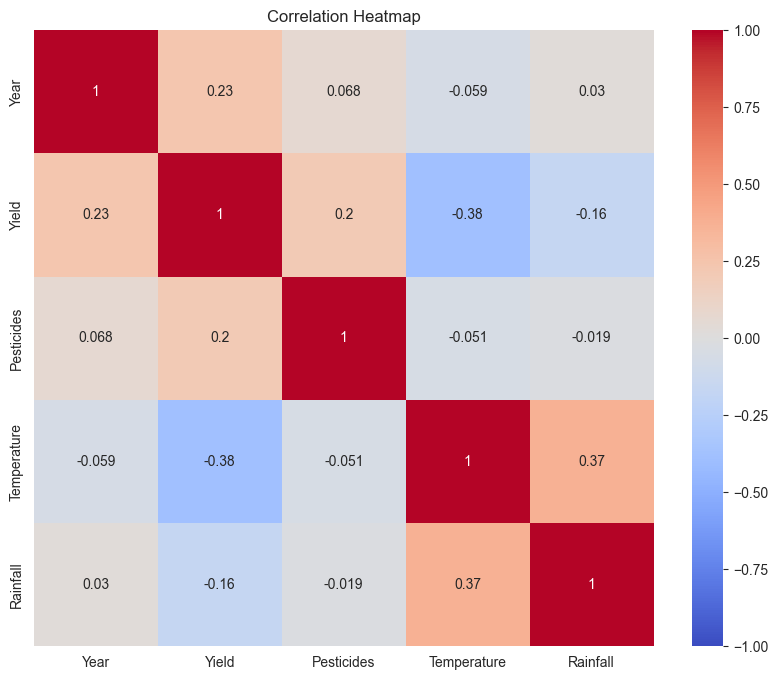

In [184]:
def plot_correlation_heatmap(df):
    """
    Plot a correlation heatmap for the given dataframe.
    """
    # Compute correlation matrix
    corr_matrix = df.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()

# Plot correlation heatmap for the merged dataset
plot_correlation_heatmap(df)


In [188]:
# Normalize the data
# Yield
yield_min = merged_df['Yield'].min()
yield_max = merged_df['Yield'].max()
merged_df['Yield_normalized'] = (merged_df['Yield'] - yield_min) / (yield_max - yield_min)

# Pesticides
pesticides_min = merged_df['Pesticides'].min()
pesticides_max = merged_df['Pesticides'].max()
merged_df['Pesticides_normalized'] = (merged_df['Pesticides'] - pesticides_min) / (pesticides_max - pesticides_min)

In [189]:
# Calculate the percentage increase for Yield and percentage decrease for Pesticides
first_values = merged_df.groupby('Country').first()
last_values = merged_df.groupby('Country').last()

yield_perc_increase = ((last_values['Yield'] - first_values['Yield']) / first_values['Yield']) * 100
pesticide_perc_decrease = ((first_values['Pesticides'] - last_values['Pesticides']) / first_values['Pesticides']) * 100

ranking_score = yield_perc_increase + pesticide_perc_decrease

ranking_df = pd.DataFrame({
    'Country': yield_perc_increase.index,
    'Yield Percentage Increase': yield_perc_increase.values,
    'Pesticide Percentage Decrease': pesticide_perc_decrease.values,
    'Ranking Score': ranking_score.values
})

ranking_df = ranking_df.sort_values(by='Ranking Score', ascending=False).reset_index(drop=True)
ranking_df.head()

,Country,Yield Percentage Increase,Pesticide Percentage Decrease,Ranking Score
0,Namibia,338.168951,80.625588,418.794539
1,Algeria,166.180650,98.534681,264.715331
2,Kazakhstan,135.699430,100.000000,235.699430
3,Bahamas,134.655536,99.636364,234.291899
4,Mongolia,131.725681,97.579948,229.305629


In [190]:
# Round the calculations to 3 decimal points
ranking_df['Yield Percentage Increase'] = ranking_df['Yield Percentage Increase'].round(3)
ranking_df['Pesticide Percentage Decrease'] = ranking_df['Pesticide Percentage Decrease'].round(3)
ranking_df['Ranking Score'] = ranking_df['Ranking Score'].round(3)
ranking_df.head()

,Country,Yield Percentage Increase,Pesticide Percentage Decrease,Ranking Score
0,Namibia,338.169,80.626,418.795
1,Algeria,166.181,98.535,264.715
2,Kazakhstan,135.699,100.000,235.699
3,Bahamas,134.656,99.636,234.292
4,Mongolia,131.726,97.580,229.306


In [191]:
# summary statistics
def data_summary(df):
    """
    Provides a summary of the data including descriptive statistics, unique values, and missing values.

    Parameters:
    - df: DataFrame to be summarized.

    Returns:
    - summary: A dictionary containing descriptive statistics, unique values, and missing values.
    """
    # Descriptive statistics
    desc_stats = df.describe().transpose()

    # Unique values for categorical columns
    unique_values = df.select_dtypes(include=['object']).nunique()

    # Missing values
    missing_values = df.isnull().sum()

    summary = {
        'Descriptive Statistics': desc_stats,
        'Unique Values': unique_values,
        'Missing Values': missing_values
    }

    return summary

# Call the function
data_summary(merged_df)

{'Descriptive Statistics':                          count          mean           std        min  \
 Year                   83358.0  2.001533e+03  6.935363e+00    1990.00   
 Yield                  83358.0  7.828520e+06  4.096672e+06  343116.00   
 Pesticides             83358.0  9.107366e+03  3.490180e+04       0.00   
 Temperature            83358.0  1.879754e+01  7.549539e+00      -3.37   
 Rainfall               83358.0  1.095263e+03  6.550240e+02      51.00   
 Yield_normalized       83358.0  1.980558e-01  1.083936e-01       0.00   
 Pesticides_normalized  83358.0  1.925540e-02  7.379172e-02       0.00   
 
                                 25%           50%           75%          max  
 Year                   1.996000e+03  2.001000e+03  2.008000e+03      2013.00  
 Yield                  5.208664e+06  7.092660e+06  1.062819e+07  38137528.00  
 Pesticides             8.500000e-01  5.509000e+01  1.858648e+03    472977.15  
 Temperature            1.243000e+01  2.005000e+01  2.599000

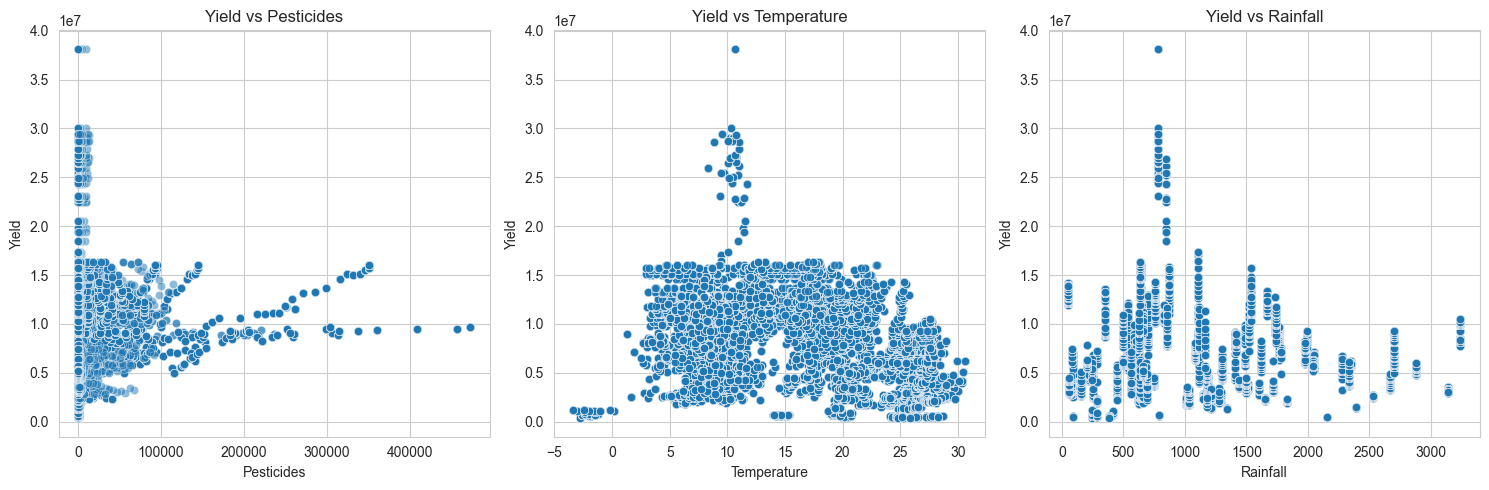

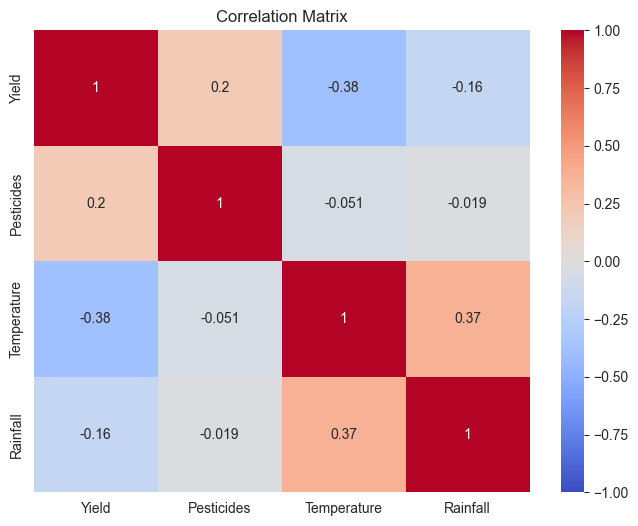

In [194]:
def relationships(df):
    """
    Plots scatter plots to analyze the relationship between variables and a correlation matrix.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Scatter plots
    plt.figure(figsize=(15, 5))

    # Yield vs Pesticides
    plt.subplot(1, 3, 1)
    sns.scatterplot(x='Pesticides', y='Yield', data=df, alpha=0.5)
    plt.title('Yield vs Pesticides')

    # Yield vs Temperature
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='Temperature', y='Yield', data=df, alpha=0.5)
    plt.title('Yield vs Temperature')

    # Yield vs Rainfall
    plt.subplot(1, 3, 3)
    sns.scatterplot(x='Rainfall', y='Yield', data=df, alpha=0.5)
    plt.title('Yield vs Rainfall')

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    correlation_matrix = df[['Yield', 'Pesticides', 'Temperature', 'Rainfall']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

# Call the function
relationships(merged_df)

- The correlation matrix provides a numerical representation of the relationships between the variables. A value closer to 1  ndicates a strong positive correlation, while a value closer to -1 indicates a strong negative correlation. From the matrix, we can observe that Yield has a positive correlation with Pesticides, a slight negative correlation with Temperature, and a very weak correlation with Rainfall.
- The use of pesticides seems to have a positive impact on the yield of crops.
Temperature and rainfall, on their own, do not seem to have a strong correlation with yield. This suggests that other factors, possibly in combination with temperature and rainfall, might be influencing the yield.

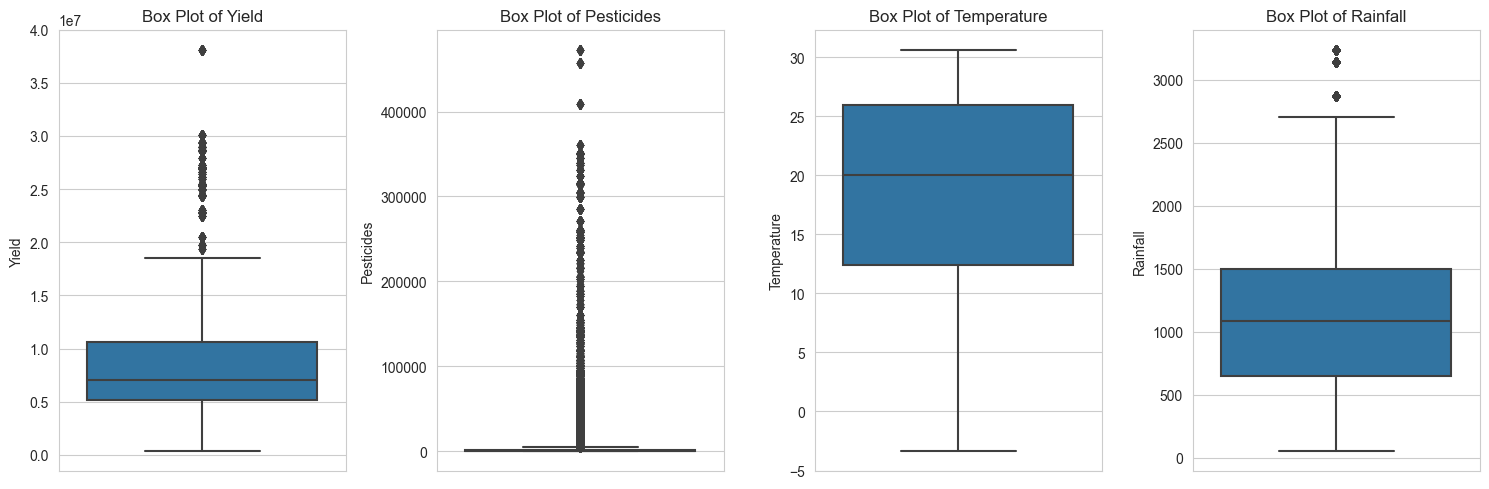

In [196]:
# Outliers detection
def detect_outliers(df, columns):
    """
    Detects outliers in the specified columns using box plots.

    Parameters:
    - df: DataFrame containing the data.
    - columns: List of column names to check for outliers.
    """
    plt.figure(figsize=(15, 5))

    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(y=df[column])
        plt.title(f'Box Plot of {column}')
        plt.ylabel(column)

    plt.tight_layout()
    plt.show()

# Detect outliers in key columns
detect_outliers(merged_df, ['Yield', 'Pesticides', 'Temperature', 'Rainfall'])

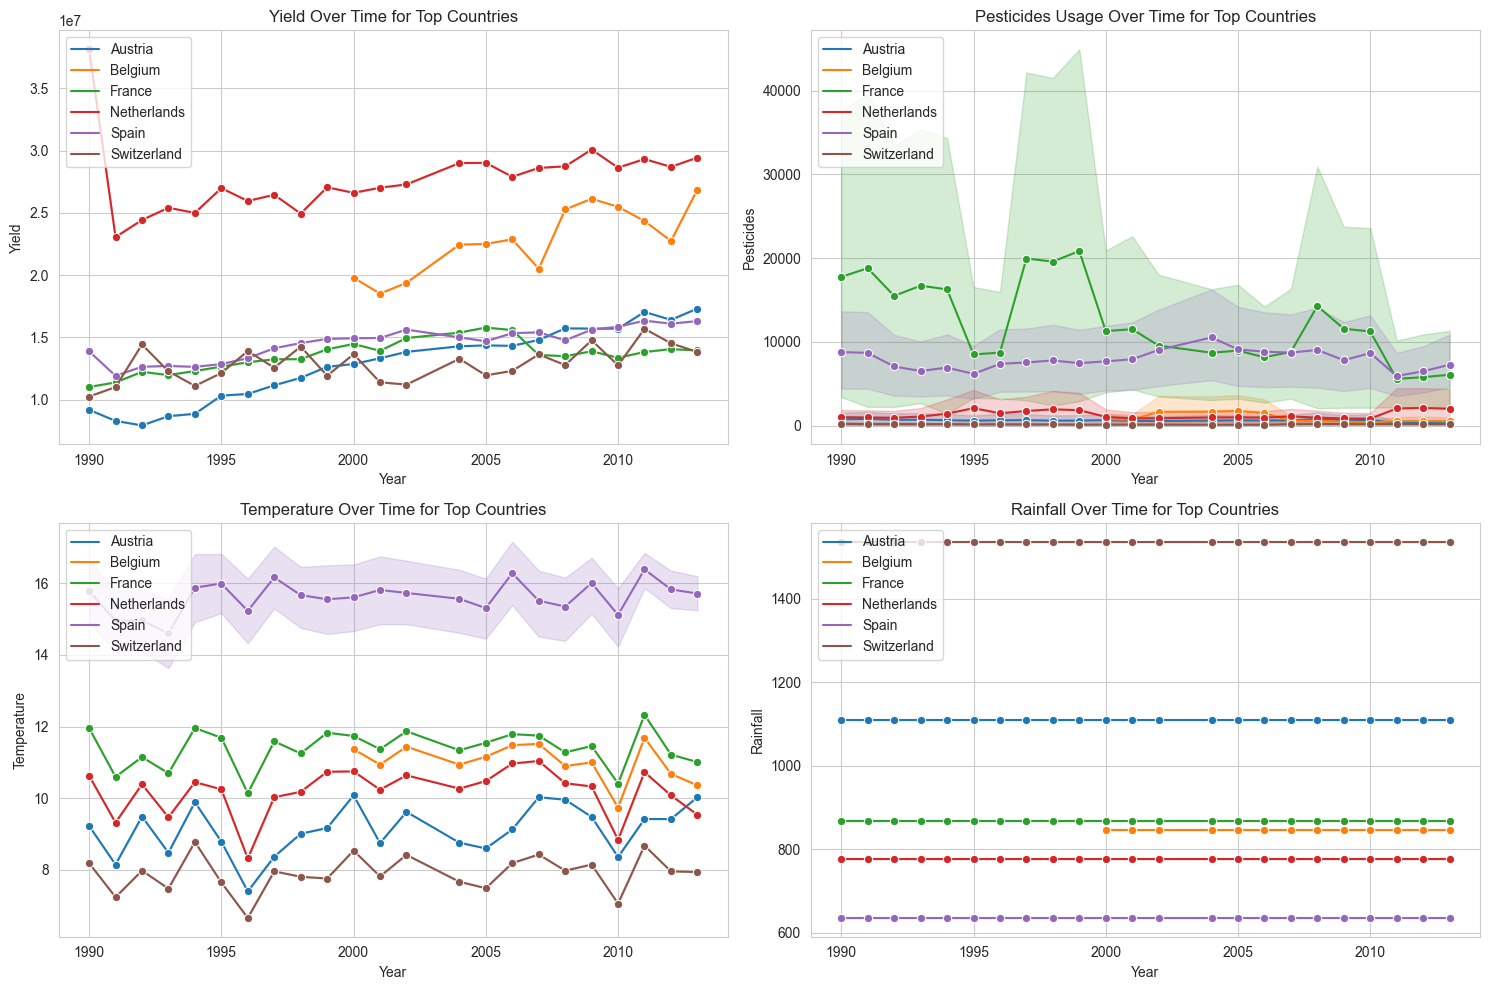

In [202]:
# The distribution of top 6 countries
def top_countries_analysis(df, top_n=6):
    """
    Analyzes the top N countries based on average yield.

    Parameters:
    - df: DataFrame containing the data.
    - top_n: Number of top countries to consider (default is 6).
    """
    # Identify the top N countries based on average yield
    top_countries = df.groupby('Country')['Yield'].mean().sort_values(ascending=False).head(top_n).index.tolist()

    # Filter the dataset for these countries
    top_countries_df = df[df['Country'].isin(top_countries)]

    # Temporal Analysis
    plt.figure(figsize=(15, 10))

    # Yield over time
    plt.subplot(2, 2, 1)
    sns.lineplot(data=top_countries_df, x='Year', y='Yield', hue='Country', marker='o')
    plt.title('Yield Over Time for Top Countries')
    plt.legend(loc='upper left')

    # Pesticides over time
    plt.subplot(2, 2, 2)
    sns.lineplot(data=top_countries_df, x='Year', y='Pesticides', hue='Country', marker='o')
    plt.title('Pesticides Usage Over Time for Top Countries')
    plt.legend(loc='upper left')

    # Temperature over time
    plt.subplot(2, 2, 3)
    sns.lineplot(data=top_countries_df, x='Year', y='Temperature', hue='Country', marker='o')
    plt.title('Temperature Over Time for Top Countries')
    plt.legend(loc='upper left')

    # Rainfall over time
    plt.subplot(2, 2, 4)
    sns.lineplot(data=top_countries_df, x='Year', y='Rainfall', hue='Country', marker='o')
    plt.title('Rainfall Over Time for Top Countries')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # Country-Specific Analysis
    country_summary = top_countries_df.groupby('Country').agg({
        'Yield': 'mean',
        'Pesticides': 'mean',
        'Temperature': 'mean',
        'Rainfall': 'mean'
    }).sort_values(by='Yield', ascending=False)

    return country_summary

# Call the function
top_countries_summary = top_countries_analysis(merged_df)

- Yield Over Time for Top Countries:
Most countries show a general upward trend in yield over the years, indicating improvements in agricultural practices or other factors contributing to higher yields.
Some countries exhibit fluctuations in yield, which could be due to various reasons such as climatic conditions, policy changes, or economic factors.

- Pesticides Usage Over Time for Top Countries:
Pesticide usage trends vary across countries. While some countries show an increase in pesticide usage, others remain relatively stable or even decrease.
The relationship between pesticide usage and yield might be influenced by the type and effectiveness of pesticides used, as well as other agronomic practices.

- Temperature Over Time for Top Countries:
Temperature trends are relatively stable for most countries, with slight fluctuations observed.
The impact of temperature on yield might vary depending on the crops grown and the specific temperature requirements for optimal growth.

- Rainfall Over Time for Top Countries:
Rainfall patterns exhibit variability across countries and over the years.
The relationship between rainfall and yield can be complex, as both insufficient and excessive rainfall can negatively impact crop growth.

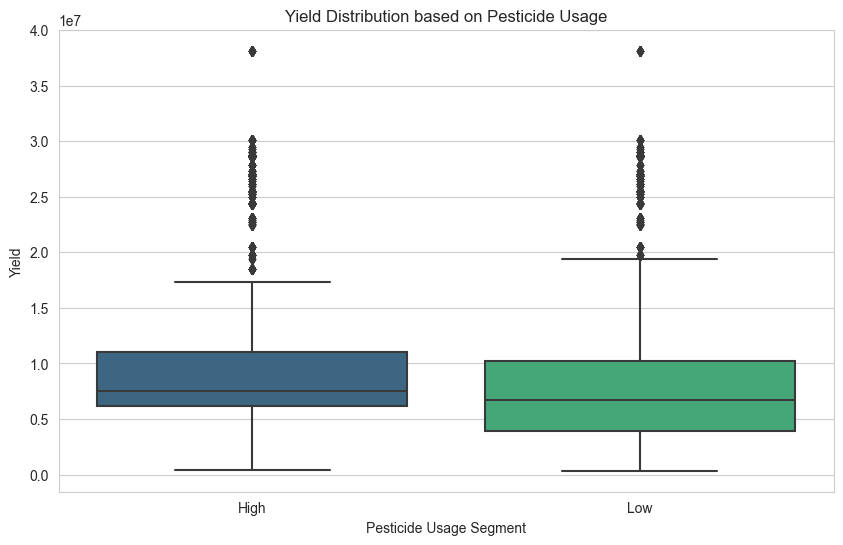

Yield                          Temperature         \
                           mean     median           std        mean median   
Pesticide_Segment                                                             
High               8.473976e+06  7491571.0  3.915724e+06   18.977607  20.03   
Low                7.183064e+06  6677926.0  4.171295e+06   18.617466  20.09   

                                Rainfall                      
                        std         mean  median         std  
Pesticide_Segment                                             
High               7.319006  1107.433192  1083.0  633.332729  
Low                7.769154  1083.092205  1020.0  675.808039

In [198]:
def segmentation_analysis(df):
    """
    Conducts segmentation analysis based on pesticide usage.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Calculate the median pesticide usage to segment the data
    median_pesticides = df['Pesticides'].median()

    # Segment the data into high and low pesticide usage based on the median
    df['Pesticide_Segment'] = df['Pesticides'].apply(lambda x: 'High' if x > median_pesticides else 'Low')

    # Plotting the yield distribution for both segments
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Pesticide_Segment', y='Yield', palette='viridis')
    plt.title('Yield Distribution based on Pesticide Usage')
    plt.ylabel('Yield')
    plt.xlabel('Pesticide Usage Segment')
    plt.show()

    # Summary statistics for the segments
    segment_summary = df.groupby('Pesticide_Segment').agg({
        'Yield': ['mean', 'median', 'std'],
        'Temperature': ['mean', 'median', 'std'],
        'Rainfall': ['mean', 'median', 'std']
    })

    return segment_summary

# Call the function
segmentation_summary = segmentation_analysis(merged_df)
segmentation_summary

There seems to be a positive relationship between pesticide usage and yield. Countries that use more pesticides tend to have higher yields.
The temperature and rainfall patterns are relatively consistent across both segments, indicating that these factors might not be the primary drivers for the differences in yield.

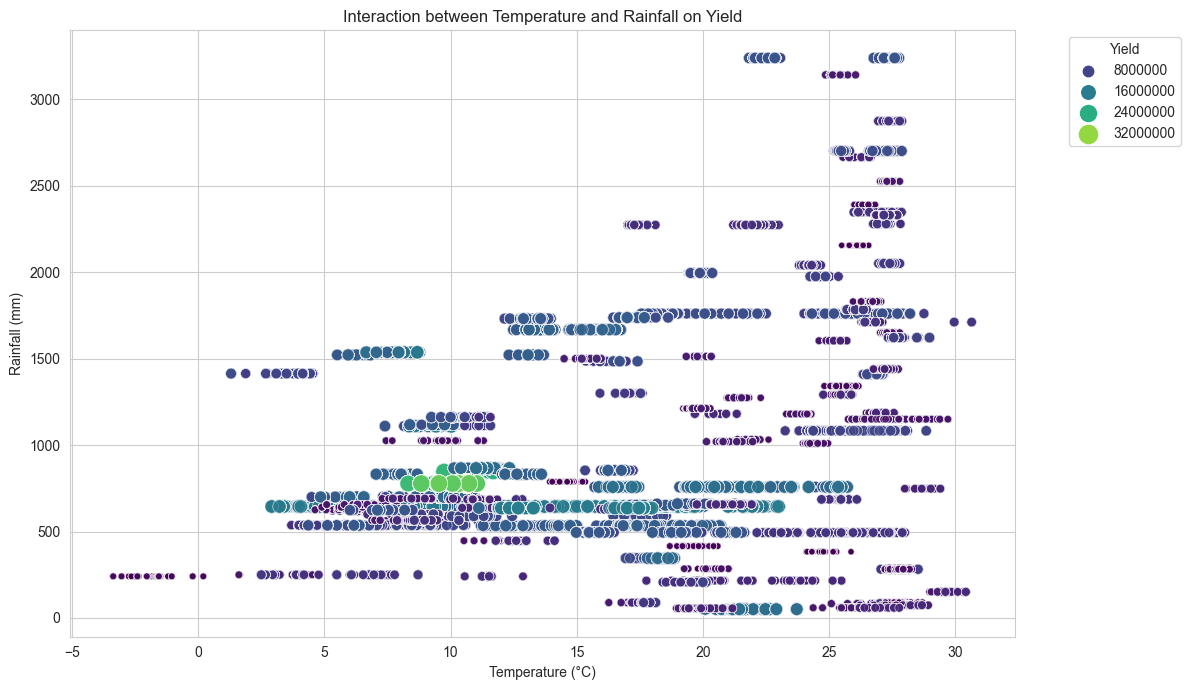

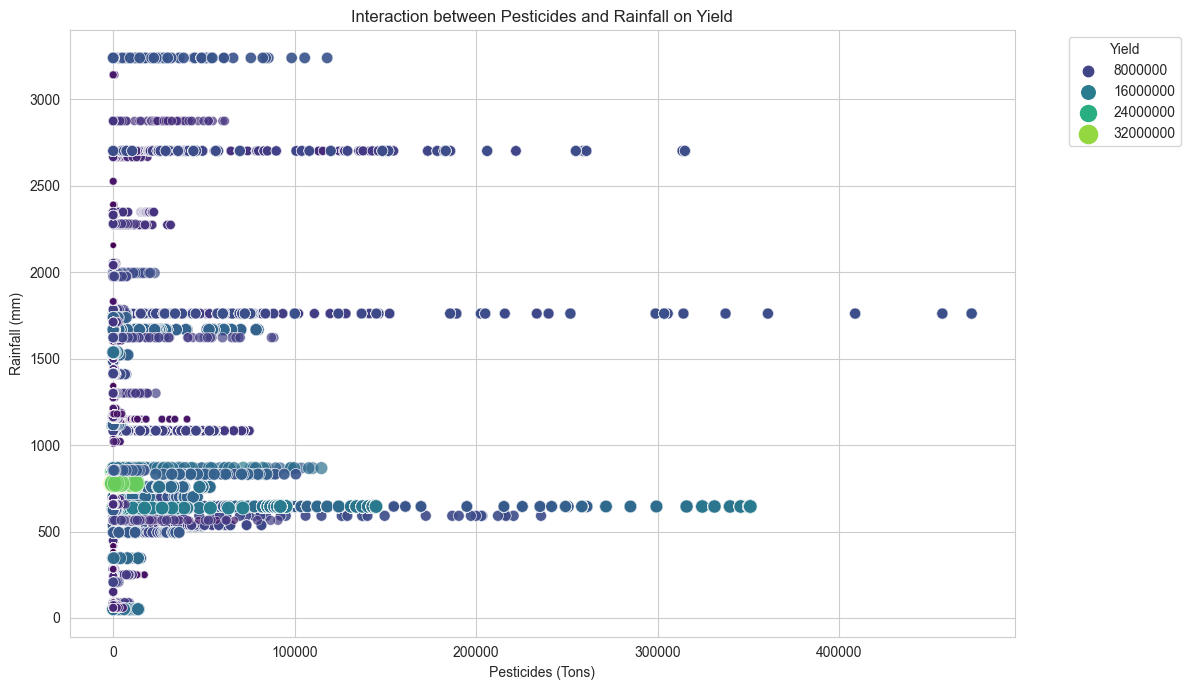

In [199]:
# Impact of interactions on yield
def interactions(df):
    """
    Explores feature interactions and their impact on yield.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Interaction between Temperature and Rainfall on Yield
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='Temperature', y='Rainfall', hue='Yield', size='Yield',
                    sizes=(20, 200), palette='viridis', alpha=0.7)
    plt.title('Interaction between Temperature and Rainfall on Yield')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Rainfall (mm)')
    plt.legend(title='Yield', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Interaction between Pesticides and Rainfall on Yield
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df, x='Pesticides', y='Rainfall', hue='Yield', size='Yield',
                    sizes=(20, 200), palette='viridis', alpha=0.7)
    plt.title('Interaction between Pesticides and Rainfall on Yield')
    plt.xlabel('Pesticides (Tons)')
    plt.ylabel('Rainfall (mm)')
    plt.legend(title='Yield', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Call the function
interactions(merged_df)

- The first plot suggests that there's a wide range of yields for similar temperature and rainfall conditions. This indicates that other factors, possibly like farming practices or soil quality, might play a significant role in determining yield.
- The second plot shows that higher pesticide usage doesn't necessarily correlate with higher yields, especially in regions with lower rainfall. This could imply that the effectiveness of pesticides might be influenced by rainfall or other environmental conditions.

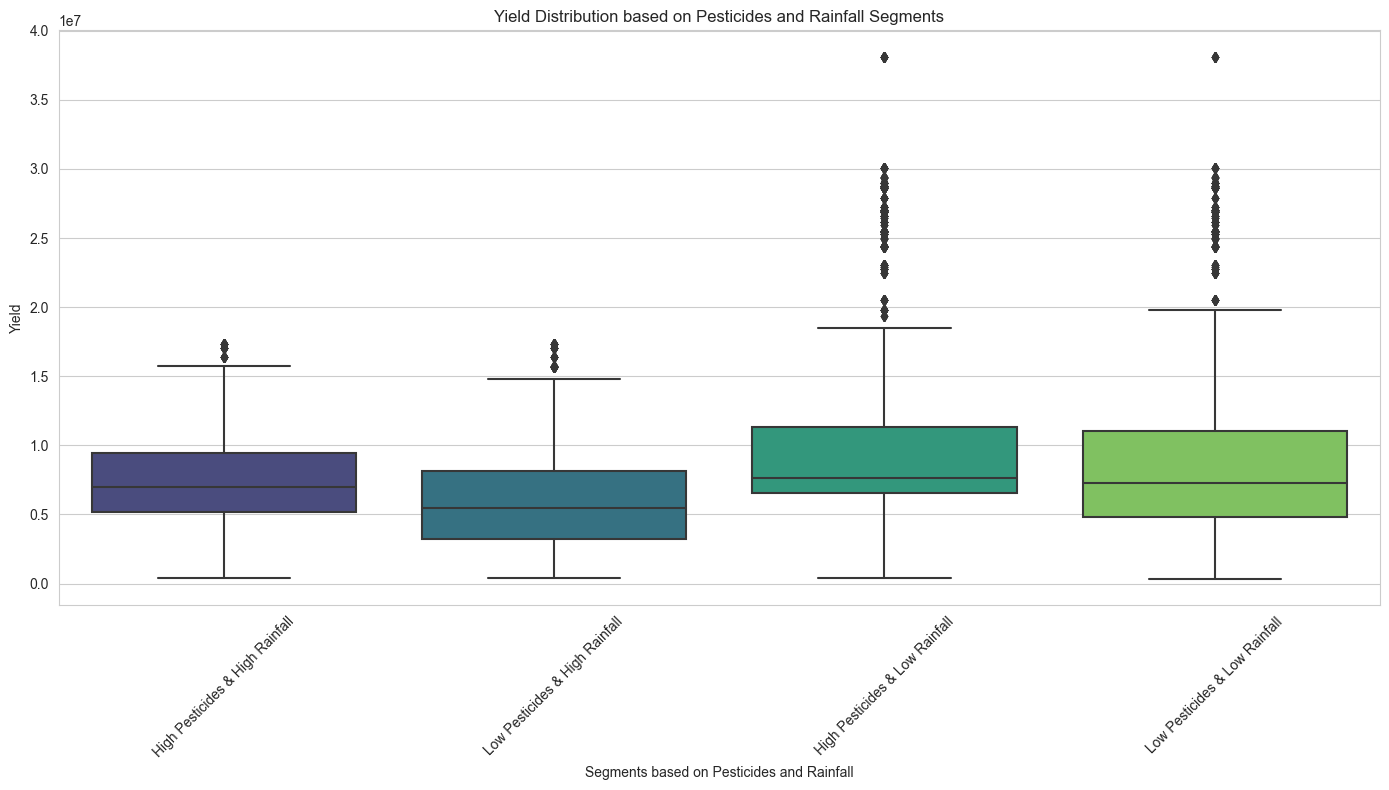

Yield                           \
                                         mean     median           std   
Segment                                                                  
High Pesticides & High Rainfall  7.412137e+06  7011532.5  3.313911e+06   
High Pesticides & Low Rainfall   9.011515e+06  7640665.0  4.083648e+06   
Low Pesticides & High Rainfall   5.884767e+06  5482916.0  3.287410e+06   
Low Pesticides & Low Rainfall    8.039925e+06  7262856.0  4.461460e+06   

                                Temperature                   
                                       mean median       std  
Segment                                                       
High Pesticides & High Rainfall   21.242105  22.63  6.281262  
High Pesticides & Low Rainfall    17.831241  18.29  7.536848  
Low Pesticides & High Rainfall    21.299561  24.63  6.806434  
Low Pesticides & Low Rainfall     16.847313  17.23  7.857581

In [200]:
# Analysis of pesticide and rainfall on yield
def pesticides_rainfall_yield(df):
    """
    Explores the deep interaction between Pesticides, Rainfall, and Yield.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Segmenting data based on median values of Pesticides and Rainfall
    median_pesticides = df['Pesticides'].median()
    median_rainfall = df['Rainfall'].median()

    conditions = [
        (df['Pesticides'] > median_pesticides) & (df['Rainfall'] > median_rainfall),
        (df['Pesticides'] <= median_pesticides) & (df['Rainfall'] > median_rainfall),
        (df['Pesticides'] > median_pesticides) & (df['Rainfall'] <= median_rainfall),
        (df['Pesticides'] <= median_pesticides) & (df['Rainfall'] <= median_rainfall)
    ]
    choices = ['High Pesticides & High Rainfall', 'Low Pesticides & High Rainfall',
               'High Pesticides & Low Rainfall', 'Low Pesticides & Low Rainfall']
    df['Segment'] = np.select(conditions, choices, default='Other')

    # Plotting the yield distribution for each segment
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Segment', y='Yield', palette='viridis')
    plt.title('Yield Distribution based on Pesticides and Rainfall Segments')
    plt.ylabel('Yield')
    plt.xlabel('Segments based on Pesticides and Rainfall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Summary statistics for each segment
    segment_summary = df.groupby('Segment').agg({
        'Yield': ['mean', 'median', 'std'],
        'Temperature': ['mean', 'median', 'std']
    })

    return segment_summary

# Call the function
deep_dive_summary = pesticides_rainfall_yield(merged_df)
deep_dive_summary

- The segment with "High Pesticides & High Rainfall" has a higher mean yield compared to the other segments. This suggests that a combination of high pesticide usage and high rainfall can lead to better yields.
- The segment with "Low Pesticides & High Rainfall" has a lower mean yield than the "High Pesticides & High Rainfall" segment, indicating that while rainfall is beneficial, the addition of pesticides can further enhance yield.
- The segments with "Low Rainfall" (both high and low pesticides) have a slightly higher yield variance, as indicated by the spread of the box plots. This suggests that in regions with low rainfall, other factors might play a more significant role in determining yield.

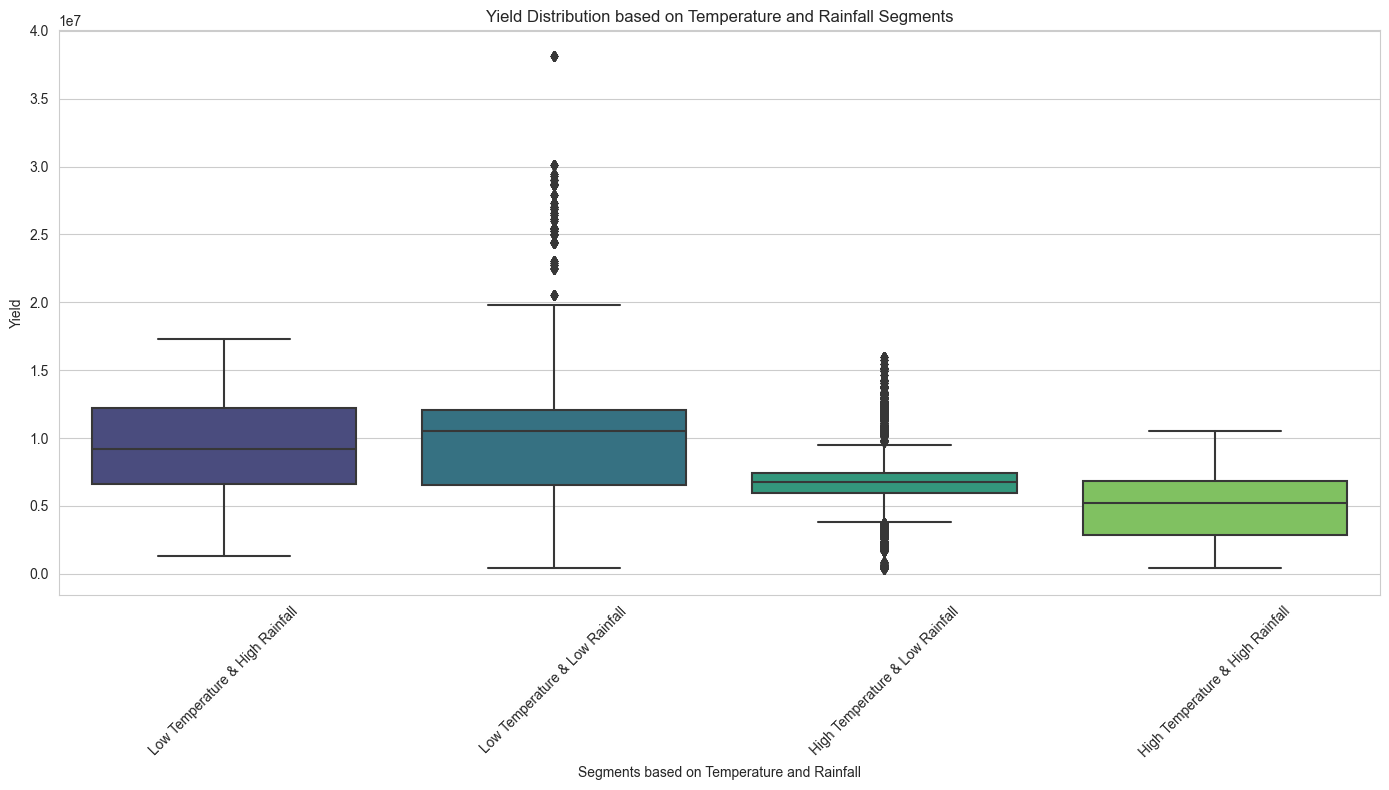

Yield                            \
                                          mean      median           std   
Segment                                                                    
High Temperature & High Rainfall  5.077913e+06   5212020.0  2.386408e+06   
High Temperature & Low Rainfall   6.763163e+06   6730968.0  2.581318e+06   
Low Temperature & High Rainfall   9.142872e+06   9224549.0  3.296521e+06   
Low Temperature & Low Rainfall    9.868067e+06  10513461.0  4.801377e+06   

                                    Pesticides                         
                                          mean   median           std  
Segment                                                                
High Temperature & High Rainfall   7437.905690   27.865  33497.269898  
High Temperature & Low Rainfall    5337.911436  162.070  19195.866156  
Low Temperature & High Rainfall    5047.982493   46.000  24350.614770  
Low Temperature & Low Rainfall    14463.907675   62.560  45746.102841

In [201]:
# Analysis of temperature and rainfall on yield
def temperature_rainfall_yield(df):
    """
    Explores the deep interaction between Temperature, Rainfall, and Yield.

    Parameters:
    - df: DataFrame containing the data.
    """
    # Segmenting data based on median values of Temperature and Rainfall
    median_temperature = df['Temperature'].median()
    median_rainfall = df['Rainfall'].median()

    conditions = [
        (df['Temperature'] > median_temperature) & (df['Rainfall'] > median_rainfall),
        (df['Temperature'] <= median_temperature) & (df['Rainfall'] > median_rainfall),
        (df['Temperature'] > median_temperature) & (df['Rainfall'] <= median_rainfall),
        (df['Temperature'] <= median_temperature) & (df['Rainfall'] <= median_rainfall)
    ]
    choices = ['High Temperature & High Rainfall', 'Low Temperature & High Rainfall',
               'High Temperature & Low Rainfall', 'Low Temperature & Low Rainfall']
    df['Segment'] = np.select(conditions, choices, default='Other')

    # Plotting the yield distribution for each segment
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Segment', y='Yield', palette='viridis')
    plt.title('Yield Distribution based on Temperature and Rainfall Segments')
    plt.ylabel('Yield')
    plt.xlabel('Segments based on Temperature and Rainfall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Summary statistics for each segment
    segment_summary = df.groupby('Segment').agg({
        'Yield': ['mean', 'median', 'std'],
        'Pesticides': ['mean', 'median', 'std']
    })

    return segment_summary

# Call the function
deep_dive_temp_rain_summary = temperature_rainfall_yield(merged_df)
deep_dive_temp_rain_summary

- The segment with "Low Temperature & Low Rainfall" has the highest mean yield, suggesting that crops in this dataset might be more suited to cooler and drier conditions.
- The segment with "High Temperature & High Rainfall" has the lowest mean yield, indicating that excessive heat combined with high rainfall might not be ideal for these crops.
- The yield variance, as indicated by the spread of the box plots, is highest for the "Low Temperature & Low Rainfall" segment, suggesting that other factors might play a significant role in determining yield in these conditions.
- Pesticide usage is highest in the "Low Temperature & Low Rainfall" segment, which might be a contributing factor to the higher yields observed in this segment.



This exploration provides valuable insights into how temperature and rainfall interact to influence crop yield. It emphasizes the importance of considering both factors together when making farming decisions and planning for future agricultural practices.